# Simplex Algorithm Implementation

This notebook implements the simplex algorithm to maximize the objective function.

**Assumptions:** Polytope is non-degenerate, bounded, and rank of A is n.

## Import Libraries

importing all neccesary librarys for algorithm

In [42]:
import csv
import numpy as np
import sympy as sp
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box
import pandas as pd
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt

console = Console()

## Read Input Data from CSV

reading the csv file which contain all input data for simplex

In [29]:
with open('testcase_1.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    data = list(reader)

# extracting initial feasable point from first row (except last column)
z = np.array([float(val) for val in data[0][:-1]])
# extracting cost vector from secound row (except last column)
c = np.array([float(val) for val in data[1][:-1]])
# extracting constraint vector b from last column of all rows starting from 3rd
b = np.array([float(row[-1]) for row in data[2:]])
# extracting constraint matix A from remaining data
A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])

# m is number of constraint, n is number of variable
m, n = len(b), len(c)

## Display Input Data

In [30]:
console.print("[bold yellow]           SIMPLEX ALGORITHM - INPUT DATA[/bold yellow]\n")

input_table = Table(show_header=True, header_style="bold magenta", box=box.ROUNDED)
input_table.add_column("Parameter", style="cyan", width=30)
input_table.add_column("Value", style="green")

input_table.add_row("Initial Feasible Point (z)", str(z))
input_table.add_row("Cost Vector (c)", str(c))
input_table.add_row("Constraint Vector (b)", str(b))
input_table.add_row("Dimensions (m × n)", f"{m} × {n}")

console.print(input_table)

           SIMPLEX ALGORITHM - INPUT DATA

╭────────────────────────────────┬────────────╮
│ Parameter                      │ Value      │
├────────────────────────────────┼────────────┤
│ Initial Feasible Point (z)     │ [0. 0.]    │
│ Cost Vector (c)                │ [5. 2.]    │
│ Constraint Vector (b)          │ [1. 1. 1.] │
│ Dimensions (m × n)             │ 3 × 2      │
╰────────────────────────────────┴────────────╯

In [31]:
display(Markdown("### Matrix A:"))
df_A = pd.DataFrame(A, columns=[f'x{i+1}' for i in range(n)],
                    index=[f'Constraint {i+1}' for i in range(m)])
display(df_A)

### Matrix A:

,x1,x2
Constraint 1,0.0,1.0
Constraint 2,1.0,0.0
Constraint 3,-1.0,-1.0


## Phase 1: Converting Feasable Point to Vertex

In this phase we will move from initial feasable point to a vertex

In [43]:
console.print("[bold yellow]        PHASE 1: Feasible Point to Vertex[/bold yellow]\n")

track_cost = [np.dot(c, z)]
track_z = [z]

# checking which constraints are tight at current point z
# constraint is tight if A*z = b (with small tolerence for numerical error)
product = np.dot(A, z)
mask = np.abs(product - b) < 1e-8
tight_rows = A[mask]
untight_rows = A[~mask]
rank = 0 if len(tight_rows) == 0 else np.linalg.matrix_rank(tight_rows)

# if rank of tight constraints equal to n, then we are at vertex!
if rank == n:
    console.print(Panel("[bold green]Already at a vertex![/bold green]", border_style="green", box=box.DOUBLE))
    z_vertex = z
    cost_to_vertex = track_cost
    path_to_vertex = track_z
else:
    console.print("[bold yellow]Not at a vertex. Searching for a vertex...[/bold yellow]\n")
    z_old = z
    z_new = z
    iteration = 0
    
    # keep moving untill rank become n (which mean we reach vertex)
    while rank != n:
        iteration += 1
        if iteration % 1 == 0:
            console.print(f"[cyan]Iteration {iteration}[/cyan] | [magenta]Rank: {rank}[/magenta]")
        
        # finding direction to move
        if len(tight_rows) == 0:
            u = np.random.rand(untight_rows.shape[-1])
        else:
            # move in direction perpendiculer to tight constraints using null space
            tight_matrix = sp.Matrix(tight_rows)
            null_space_vectors = tight_matrix.nullspace()
            u = np.array(null_space_vectors[0]).astype(float).flatten()
        
        # calculating how far we can move before hitting new constraint
        alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) 
                  for b_i, a2_i in zip(b[~mask], untight_rows)]
        alpha = min([a for a in alphas if a > 0])
        
        z_new = z_old + alpha * u
        product = np.dot(A, z_new)
        mask = np.abs(product - b) < 1e-8
        tight_rows = A[mask]
        untight_rows = A[~mask]
        z_old = z_new
        
        rank = 0 if len(tight_rows) == 0 else np.linalg.matrix_rank(tight_rows)
        track_cost.append(np.dot(c, z_new))
        track_z.append(z_new)
    
    console.print(f"\n[bold green]Vertex found! | Rank: {rank}[/bold green]")
    z_vertex = z_new
    cost_to_vertex = track_cost
    path_to_vertex = track_z

        PHASE 1: Feasible Point to Vertex

Not at a vertex. Searching for a vertex...

Iteration 1 | Rank: 0

Iteration 2 | Rank: 1

Vertex found! | Rank: 2

### Phase 1 Results

In [44]:
console.print("\n[bold]Initial Vertex:[/bold]", style="yellow")
console.print(Panel(str(z_vertex), border_style="yellow", box=box.ROUNDED))
console.print(f"[bold]Costs during Phase 1:[/bold]")
print(cost_to_vertex)

Initial Vertex:

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ [1. 1.]                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Costs during Phase 1:

[np.float64(0.0), np.float64(6.610755252242697), np.float64(7.0)]


### Phase 1: Cost Progression

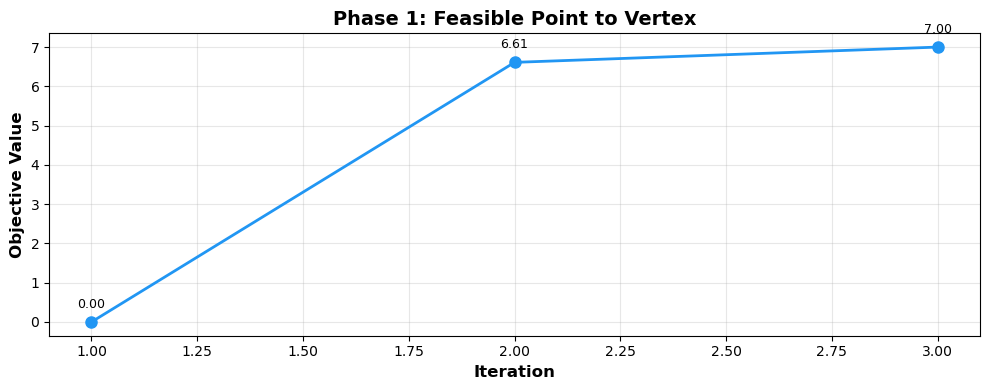

In [45]:
display(Markdown("### Phase 1: Cost Progression"))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(cost_to_vertex) + 1), cost_to_vertex, 
        marker='o', linewidth=2, markersize=8, color='#2196F3')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax.set_title('Phase 1: Feasible Point to Vertex', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, cost in enumerate(cost_to_vertex):
    ax.annotate(f'{cost:.2f}', (i+1, cost), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

## Phase 2: Moving from Vertex to Optimal Vertex

In [46]:
console.print("[bold yellow]       PHASE 2: Vertex to Optimal Vertex[/bold yellow]\n")

track_cost = [np.dot(c, z_vertex)]
track_vertex = [z_vertex]
z_old = z_vertex
iteration = 0

# keep going untill we reach optimal vertex
while True:
    iteration += 1
    console.print(f"[cyan]Iteration {iteration}[/cyan]")
    
    product = np.dot(A, z_old)
    mask = np.abs(product - b) < 1e-8
    tight_rows = A[mask]
    untight_rows = A[~mask]
    
    # calculating all posible directions we can move from this vertex
    try:
        directions = (-np.linalg.inv(tight_rows)).T
    except np.linalg.LinAlgError:
        console.print(Panel("[bold red]Matrix is singular. Cannot compute the inverse.[/bold red]", border_style="red", box=box.DOUBLE))
        z_optimal = z_old
        cost_to_optimal = track_cost
        path_to_optimal = track_vertex
        break
    
    # filtering only those directions which increase the objective function
    positive_directions = [d for d in directions if np.dot(d, c) > 0]
    
    # if no direction increase objective, we are at optimal vertex!
    if not positive_directions:
        console.print(Panel("[bold green]Reached the optimal vertex![/bold green]", border_style="green", box=box.DOUBLE))
        z_optimal = z_old
        cost_to_optimal = track_cost
        path_to_optimal = track_vertex
        break
    
    u = positive_directions[0]
    
    # calculating how far we can go before hitting another constraint
    alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) 
              for b_i, a2_i in zip(b[~mask], untight_rows)]
    positive_alphas = [a for a in alphas if a > 0]
    console.print(f"  [dim]Positive alphas count: {len(positive_alphas)}[/dim]")
    alpha = min(positive_alphas)
    
    z_new = z_old + alpha * u
    z_old = z_new
    
    track_cost.append(np.dot(c, z_new))
    track_vertex.append(z_new)

       PHASE 2: Vertex to Optimal Vertex

Iteration 1

╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Reached the optimal vertex!                                                                                     ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

### Phase 2 Results

In [47]:
console.print("\n[bold]Optimal Vertex:[/bold]", style="green")
console.print(Panel(str(z_optimal), border_style="green", box=box.ROUNDED))
console.print(f"[bold]Costs during Phase 2:[/bold]")
print(cost_to_optimal)

Optimal Vertex:

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ [1. 1.]                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Costs during Phase 2:

[np.float64(7.0)]


### Phase 2: Cost Progression

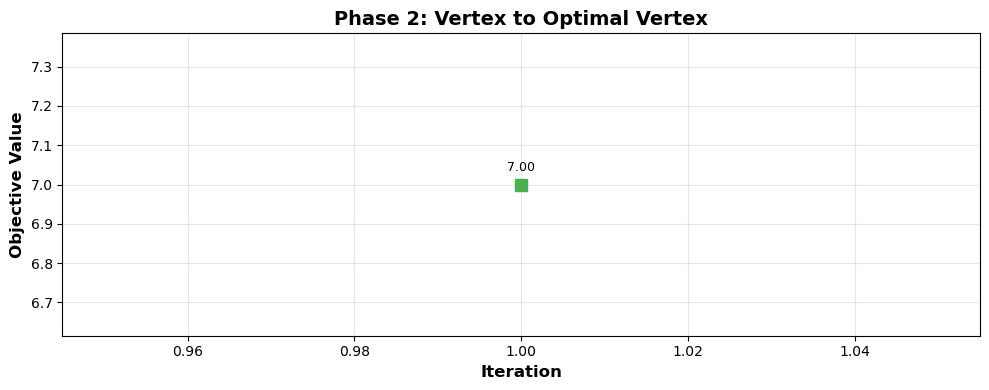

In [48]:
display(Markdown("### Phase 2: Cost Progression"))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(cost_to_optimal) + 1), cost_to_optimal, 
        marker='s', linewidth=2, markersize=8, color='#4CAF50')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax.set_title('Phase 2: Vertex to Optimal Vertex', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, cost in enumerate(cost_to_optimal):
    ax.annotate(f'{cost:.2f}', (i+1, cost), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

## Final Summary

In [49]:
console.print("[bold yellow]                    SUMMARY[/bold yellow]\n")

summary_table = Table(show_header=True, header_style="bold magenta", box=box.DOUBLE)
summary_table.add_column("Metric", style="cyan", width=35)
summary_table.add_column("Value", style="green", width=20)

# we subtract 1 because last vertex of phase 1 is same as first vertex of phase 2
total_vertices = len(path_to_vertex) + len(path_to_optimal) - 1
summary_table.add_row("All vertices visited", str(total_vertices))
summary_table.add_row("Optimal objective value", f"{cost_to_optimal[-1]:.6f}")
summary_table.add_row("Optimal solution", str(z_optimal))

console.print(summary_table)
console.print("\n[bold green]Simplex algorithm completed successfully![/bold green]\n")

                    SUMMARY

╔═════════════════════════════════════╦══════════════════════╗
║ Metric                              ║ Value                ║
╠═════════════════════════════════════╬══════════════════════╣
║ All vertices visited                ║ 3                    ║
║ Optimal objective value             ║ 7.000000             ║
║ Optimal solution                    ║ [1. 1.]              ║
╚═════════════════════════════════════╩══════════════════════╝

Simplex algorithm completed successfully!

### Combined Visualization

### Combined Cost Progression (Both Phases)

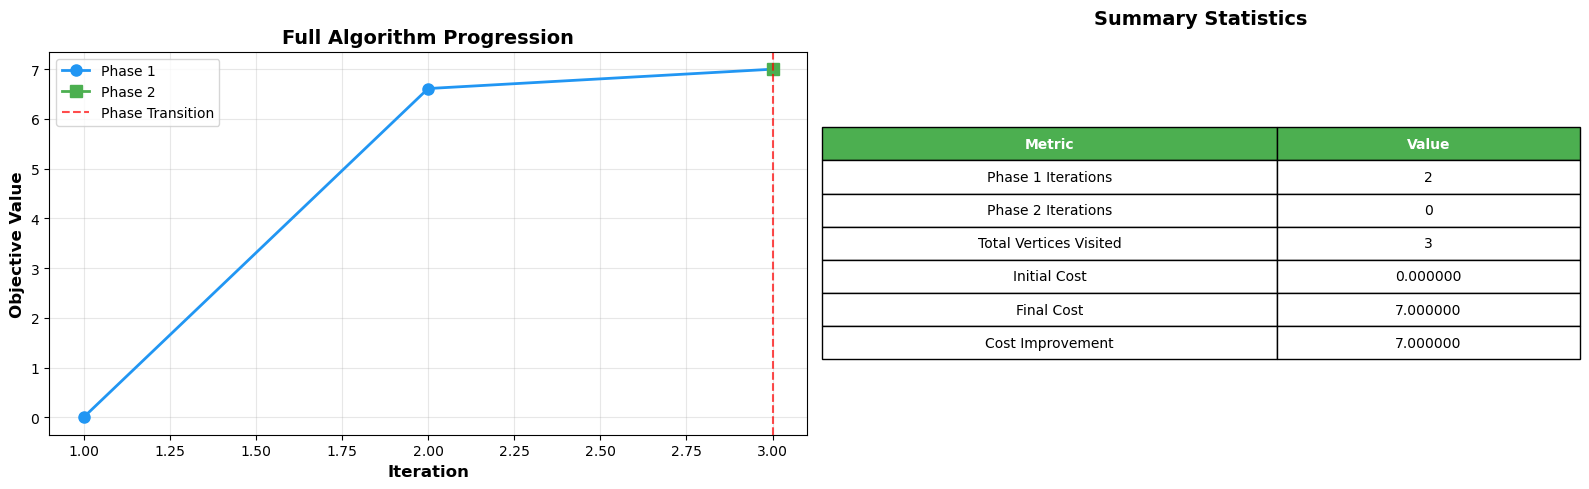

In [50]:
display(Markdown("### Combined Cost Progression (Both Phases)"))
all_costs = cost_to_vertex + cost_to_optimal[1:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(range(1, len(cost_to_vertex) + 1), cost_to_vertex, 
         marker='o', linewidth=2, markersize=8, color='#2196F3', label='Phase 1')
phase2_x = range(len(cost_to_vertex), len(cost_to_vertex) + len(cost_to_optimal))
ax1.plot(phase2_x, cost_to_optimal, 
         marker='s', linewidth=2, markersize=8, color='#4CAF50', label='Phase 2')
ax1.axvline(x=len(cost_to_vertex), color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax1.set_title('Full Algorithm Progression', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.axis('tight')
ax2.axis('off')
summary_data = {
    'Metric': ['Phase 1 Iterations', 'Phase 2 Iterations', 'Total Vertices Visited', 
               'Initial Cost', 'Final Cost', 'Cost Improvement'],
    'Value': [len(cost_to_vertex) - 1, len(cost_to_optimal) - 1, total_vertices,
              f'{cost_to_vertex[0]:.6f}', f'{cost_to_optimal[-1]:.6f}',
              f'{cost_to_optimal[-1] - cost_to_vertex[0]:.6f}']
}
df_summary = pd.DataFrame(summary_data)
table = ax2.table(cellText=df_summary.values, colLabels=df_summary.columns,
                  cellLoc='center', loc='center', 
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(df_summary.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax2.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()